## GeostatsPy: Basic Univariate Statistics and Distribution Plotting for Subsurface Data Analytics in Python 


### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Demonstration of Spatial Boostrap 
Contact: Michael Pyrcz, University of Texas at Austin, Geostatistics Course

Steps:
1. Build an initial sample set with $ndata$ samples.  Specify locations.  Sort the data in a data only array for 
   an equal weighted cumulative density function (CDF) for backtransform
2. Calculate the covariance matrix (between the data) for LU simulation.  This provides a fast and easy method
   to calculate spaitally correlated, unconditional, Gaussian realizations at the data locations.
3. Perform LU (lower upper) decomposition of the covariance matrix.  Realizations only require L x random vector.
4. Draw from this initial sample set, with replacement, $ndata$ times to build a new realization of the sample.  
   Repeat this $nreal$ times to make realizations of the sample.  Use LU simulation to ensure spaital correlation 
   between samples.  Backtransform from Gaussian to original data values (use percentiles to sample).
5. Calculate the statistic of interest for each realization. This demonstration considers the mean only.  
   We could have considered any statistic including median, 13th percentile, skew etc. 
6. (and 7.) Quantify and visualize uncertainty with histograms and summary statistics.

References:

Efron, 1982, The jackknife, the bootstrap, and other resampling plans, Society of Industrial and Applied Math, 
CBMS-NSF Monographs, 38.

Journel, A. G. Resampling from stochastic simulations. Environmental and Ecological Statistics, 1:63–84, 1994.

#### Import Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
# Imports 
import pprint
import math
import scipy
import scipy.linalg                # SciPy Linear Algebra Library
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [2]:
os.chdir("c:/PGE383")             # set the working directory

NameError: name 'os' is not defined

#### Assume Data Values and Locations

For demonstration I assume 4 data values in 2D and make a CDF by sorting for the back transform from Gaussian.

In [6]:
# 1. Make Spatial Dataset and Define Number of Realizations (just need a sufficient number to summarize uncertainty)
nreal = 100                                               # User Specified
# Assign Data Values - assume 4 data locations
ndata = 4                                                 # User Specified
output = np.zeros((ndata,nreal))  # x, y, value 
data = np.zeros((ndata,3))  # x, y, value 
data[0,0] = 25.0;  data[0,1] = 50.0;  data[0,2] = 2.3     # User Specified
data[1,0] = 75.0;  data[1,1] = 80.0;  data[1,2] = 5.5     # User Specified
data[2,0] = 10.0;  data[2,1] = 25.0;  data[2,2] = 7.0     # User Specified
data[3,0] = 95.0;  data[3,1] = 15.0;  data[3,2] = 8.7     # User Specified
# Set up backtransform lookup table
value = np.zeros(ndata) 
for i in range(0, ndata):
    value[i] = data[i,2]
print(data) 
value.sort()
print(value)

# data in ascending 

[[25.  50.   2.3]
 [75.  80.   5.5]
 [10.  25.   7. ]
 [95.  15.   8.7]]
[2.3 5.5 7.  8.7]


#### Calculate the Covariance Matrix

The covariance matrix is calculated from the distance matrix assuming a isotropic spherical variogram with range set as $var_range$. 

In [7]:
# 2. Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified, var_range
cov = np.zeros((ndata,ndata))
var_range = 100.0                                          # User Specified
for i in range(0, ndata):
    for j in range(0, ndata):
        distance = math.sqrt(math.pow((data[i,0]-data[j,0]),2) + math.pow((data[i,1]-data[j,1]),2))
        cova = 0.0
        if(distance < var_range):
            hr = distance / var_range
            cova = 1.0 - hr*(1.5 - 0.5*hr*hr)  # spherical structure, no nugget
            cov[i,j] = cova
cov

array([[1.        , 0.2244834 , 0.57506938, 0.06574285],
       [0.2244834 , 1.        , 0.03145365, 0.13715671],
       [0.57506938, 0.03145365, 1.        , 0.0296663 ],
       [0.06574285, 0.13715671, 0.0296663 , 1.        ]])

#### LU Decomposition

Peform LU decomposition to calculate the needed lower matrix $L$.

In [8]:
# 3. Perform LU Decomposition using scipy (used tutorial at www.quantstart.com) 
P, L, U = scipy.linalg.lu(cov)
print(L);  print(U)

[[ 1.          0.          0.          0.        ]
 [ 0.2244834   1.          0.          0.        ]
 [ 0.57506938 -0.10282133  1.          0.        ]
 [ 0.06574285  0.12889386  0.00674212  1.        ]]
[[ 1.          0.2244834   0.57506938  0.06574285]
 [ 0.          0.9496072  -0.09763988  0.12239854]
 [ 0.          0.          0.65925575  0.00444478]
 [ 0.          0.          0.          0.97987149]]


In [9]:
# Test the LU Decomposition (available for testing only)
#Test = cov - np.matmul(L,U)
#Test  # should be zeros

#### Calculate the Realizations

The following steps:

1. Matrix multiplication of the nxn lower matrix with a 1D matrix of random standard normal values to calculate a realization with spatial correlation at data locations $i = 0,\ldots,n-1$.

2. Convert to p-values with the standard normal CDF

3. Transform to discrete values in the data CDF.

Realizations stored in output.

In [10]:
# 4. Calculate Unconditional Realization at the Specified Locations from the Data Distribution with Replacement
#    Realizations in Gaussian space are converted to p-values and then applied to draw from the original distribution
rand = np.zeros(ndata); pvalue = np.zeros(ndata)
for ireal in range(0, nreal):    
    for i in range(0, ndata):
        rand[i] = np.random.normal()
    realization = np.matmul(L,rand)
# Convert to p-values    
    for i in range(0, ndata):
        pvalue[i] = norm.cdf(realization[i])
# Complete backtransform by selecting percentiles from original cdf (drawing with replacement from provided data values)       
        index = int(round( ndata * pvalue[i] - 0.5))
        output[i,ireal] = value[index]
idata = 0; ireal = 0
output[idata,ireal]

7.0

#### Calculate the Target Statistic for Each Realization

In [11]:
# 5. Calculate the summary statistic of interest (mean only for this example)
# Any summary statistic may be calculated.
summary = np.zeros(nreal) 
for ireal in range(0, nreal): 
    mean = 0
    for i in range(0, ndata):
        mean = mean + output[i,ireal]    
    mean = mean / ndata
    summary[ireal] = mean
summary

array([5.875, 4.7  , 3.1  , 5.875, 6.675, 6.25 , 6.675, 6.25 , 6.25 ,
       5.875, 7.1  , 6.675, 5.875, 7.9  , 5.075, 6.675, 4.65 , 5.875,
       7.85 , 5.45 , 8.275, 7.05 , 5.875, 3.9  , 5.075, 3.1  , 8.7  ,
       7.85 , 6.675, 6.25 , 8.275, 5.45 , 8.7  , 7.05 , 8.275, 7.475,
       5.5  , 6.675, 7.05 , 4.7  , 7.475, 5.075, 5.075, 5.875, 6.3  ,
       3.9  , 5.875, 7.05 , 5.075, 8.275, 7.475, 4.65 , 6.3  , 5.45 ,
       8.275, 5.45 , 7.475, 8.275, 7.1  , 7.85 , 5.875, 7.05 , 5.075,
       7.05 , 6.625, 6.3  , 6.3  , 3.1  , 4.275, 6.3  , 3.9  , 6.3  ,
       5.875, 5.875, 8.275, 5.45 , 7.475, 6.25 , 5.875, 6.25 , 4.7  ,
       5.825, 4.275, 7.475, 8.275, 3.9  , 7.475, 5.5  , 4.275, 4.7  ,
       5.875, 6.25 , 5.075, 3.1  , 3.475, 5.075, 8.275, 6.3  , 3.475,
       4.275])

C:\Users\pm27995\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


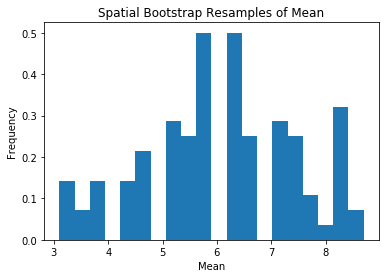

In [12]:
# 6. Visualize the summary statistic, calculate the variance or any other measure of spread to represent uncertainty in
#    the summary statistic.
plt.hist(summary,bins=20,normed=True)
plt.title("Spatial Bootstrap Resamples of Mean")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.show()

In [13]:
# 7. Summary statistics to describe uncertainty in the mean from bootstrap
columns = ['mean']
df_mean = pd.DataFrame(summary,columns=columns)
df_mean.describe()

,mean
count,100.00000
mean,6.07875
std,1.41530
min,3.10000
25%,5.07500
50%,6.25000
75%,7.05000
max,8.70000


#### Summary of Exercise

What did we learn?
1. Uncertainty decreases rapidly as the number of data samples increases.
2. Bootstrap result for uncertainty in the mean is the same as standard error if uncorrelated and more if spatially correlated.
3. Spatial bootstrap provides uncertainty in any statistic.
4. Spatial bootstrap does account for spatial context, location of data and spatial correlation.  Resampling from realizations
   taught by Journel is available to account for spatial trends, conditioning data, and secondary information.

#### Comments

This was a basic demonstration of spatial bootstrap. Much more could be done, I have other demonstrations on basics of working with DataFrames, ndarrays and many other workflows availble at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy.

I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)